# 03 - Predictability & Universe Filtering

1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions


In [1]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import pandas as pd


from tqdm import tqdm
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()
_ohlcv=ohlcv_df.copy()

In [3]:
# CROP THE SAMPLE =======================================
tickers = ohlcv_df['symbol'].unique()

[CACHE] Loading existing study from data/experiments/predictability_metrics-303b48efb13ccc05989e7c6f00903bf357f0d66e8958b9f5e0e1c2272fc9d353.csv


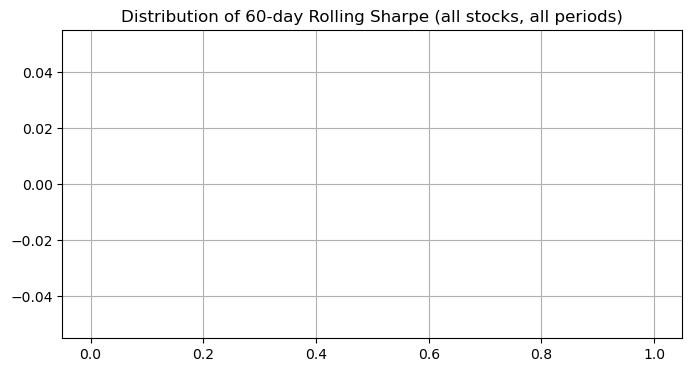

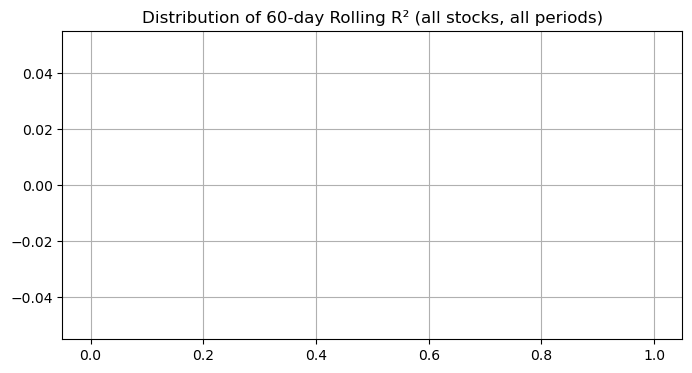

Top tickers by 60-day Sharpe in last period:


,ticker,sharpe,r2


C:\Users\Francisco Sá\Dev\RL-Stock-Market-Masterpiece-Human-x-AI-Collab\src\predictability\visualize.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(pivot.T, aspect='auto', interpolation='none', cmap='RdYlGn')
C:\Users\Francisco Sá\Dev\RL-Stock-Market-Masterpiece-Human-x-AI-Collab\src\predictability\visualize.py:12: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(pivot.T, aspect='auto', interpolation='none', cmap='RdYlGn')


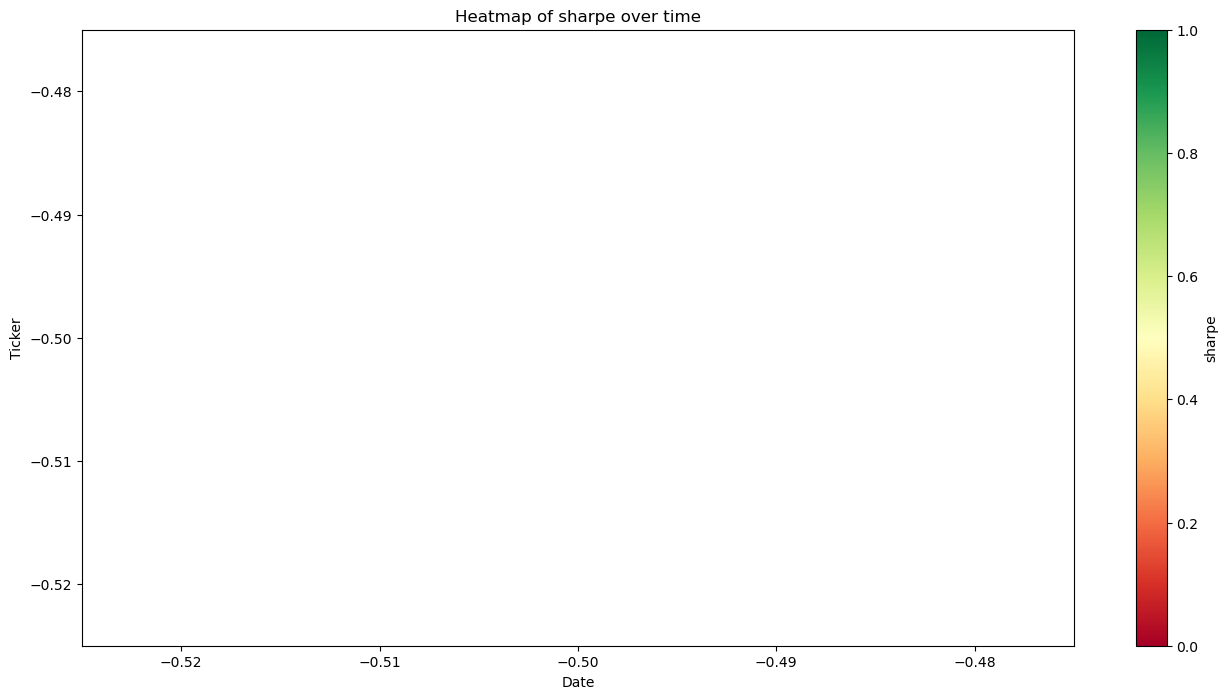

Sample of top 5 per date:


C:\Users\Francisco Sá\Dev\RL-Stock-Market-Masterpiece-Human-x-AI-Collab\src\predictability\pipeline.py:179: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('sharpe', ascending=False).head(5))


,ticker,date,return_1d,sharpe,r2,info_ratio,autocorr,sortino,calmar,hurst,aprox_entropy,variance_ratio,hmm_loglik,volatility_regimes,avg_dollar_volume,spread_proxy,config_hash,config_json


In [10]:
tickers=["BIIB","FE","KO"]
all_metric = generate_universe_easiness_report(ohlcv_df,tickers)

In [9]:
all_metric

,ticker,date,return_1d,sharpe,r2,info_ratio,autocorr,sortino,calmar,hurst,aprox_entropy,variance_ratio,hmm_loglik,volatility_regimes,avg_dollar_volume,spread_proxy,config_hash,config_json


# Walkforward study

In [6]:

#ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = _ohlcv.copy()
# Walkforward parameters
start_date = pd.to_datetime('2023-05-01')
end_date = ohlcv_df['date'].max()
freq = '6MS'   # Month Start, use 'W' for weekly, etc
window_length = 60
#tickers = ohlcv_df['ticker'].unique()

walkforward_dates = pd.date_range(start=start_date + pd.Timedelta(days=window_length), end=end_date, freq=freq)

walkforward_dates

DatetimeIndex(['2023-07-01', '2024-01-01', '2024-07-01', '2025-01-01'], dtype='datetime64[ns]', freq='6MS')

In [7]:
prev_date = "2023-01-01"
tickers = ohlcv_df['symbol'].unique()

for cutoff in tqdm(walkforward_dates):
    df = ohlcv_df.copy()
    cutoff_str = cutoff.strftime('%Y-%m-%d')
    
    print(f"\n=== Universe study up to {cutoff_str} ===")
    _ = generate_universe_easiness_report(
        ohlcv_df=df,
        tickers=tickers,
        window_length=window_length,
        target="return_1d",
        benchmark_col="market_return_1d",
        visualize=False,   # Skip plotting for speed, or True for debug
        cutoff_end_date=cutoff_str,
        cutoff_start_date=prev_date,
        save_csv_path="data/experiments/predictability_metrics-{hash}-{start}-{cutoff}.csv".format(hash="{hash}", cutoff=cutoff_str,start=prev_date)
    )
    prev_date = cutoff_str

  0%|          | 0/4 [00:00<?, ?it/s]


=== Universe study up to 2023-07-01 ===



  0%|          | 0/504 [00:00<?, ?it/s]Model is not converging.  Current: 156.19143452194112 is not greater than 156.20832348678408. Delta is -0.01688896484296265
Model is not converging.  Current: 156.42445790957163 is not greater than 156.4268173388431. Delta is -0.00235942927147903
Model is not converging.  Current: 154.48819579557227 is not greater than 154.51191198066712. Delta is -0.02371618509485529
Model is not converging.  Current: 157.1588374242403 is not greater than 157.1946972785142. Delta is -0.03585985427392302
Model is not converging.  Current: 155.53863583267017 is not greater than 155.57477135400546. Delta is -0.03613552133529652
Model is not converging.  Current: 155.42606593078025 is not greater than 155.42951929798002. Delta is -0.003453367199767854
Model is not converging.  Current: 157.87897893507417 is not greater than 157.90966039941327. Delta is -0.030681464339096465
Model is not converging.  Current: 157.74320647012752 is not greater than 157.80032484613554.

Model is not converging.  Current: 156.7294184823534 is not greater than 156.73489232726925. Delta is -0.005473844915854897
Model is not converging.  Current: 158.07976336243877 is not greater than 158.0924828109838. Delta is -0.01271944854502749
Model is not converging.  Current: 148.6617070039519 is not greater than 148.67411093105946. Delta is -0.012403927107556001

  0%|          | 1/504 [00:23<3:20:29, 23.92s/it]Model is not converging.  Current: 154.08531457114563 is not greater than 154.10855251375034. Delta is -0.023237942604708905
Model is not converging.  Current: 151.65537082571836 is not greater than 151.66287679948326. Delta is -0.007505973764892815
Model is not converging.  Current: 151.682881543655 is not greater than 151.69224508100592. Delta is -0.009363537350935758
Model is not converging.  Current: 149.73051113256417 is not greater than 149.74903590996703. Delta is -0.018524777402859627
Model is not converging.  Current: 149.27350205652522 is not greater than 149.283

Model is not converging.  Current: 143.22135904814647 is not greater than 143.23428669905397. Delta is -0.01292765090749981
Model is not converging.  Current: 147.32867170899976 is not greater than 147.38703212378505. Delta is -0.058360414785283865
Model is not converging.  Current: 143.03603094639803 is not greater than 143.04392735281417. Delta is -0.00789640641613687
Model is not converging.  Current: 145.72415765596685 is not greater than 145.76950839060058. Delta is -0.04535073463372896
Model is not converging.  Current: 145.79420248110802 is not greater than 145.85903205818417. Delta is -0.06482957707615356
Model is not converging.  Current: 146.08449676221142 is not greater than 146.13682826211357. Delta is -0.052331499902152245
Model is not converging.  Current: 146.96188269153552 is not greater than 147.0323435723411. Delta is -0.07046088080556956
Model is not converging.  Current: 130.31500317887946 is not greater than 130.350130103941. Delta is -0.035126925061547354
Model is

Model is not converging.  Current: 153.98346952541343 is not greater than 154.0303577353573. Delta is -0.046888209943887205
Model is not converging.  Current: 153.29353727118152 is not greater than 153.35251420777635. Delta is -0.058976936594831386
Model is not converging.  Current: 149.83587868950536 is not greater than 149.83639611221614. Delta is -0.0005174227107715978
Model is not converging.  Current: 151.89196060057446 is not greater than 151.99411854452345. Delta is -0.10215794394898126
Model is not converging.  Current: 152.49869511657536 is not greater than 152.52695136632823. Delta is -0.028256249752871554
Model is not converging.  Current: 153.25275938831615 is not greater than 153.37618782747856. Delta is -0.12342843916241009
Model is not converging.  Current: 153.04628271651555 is not greater than 153.05749207864835. Delta is -0.01120936213280288
Model is not converging.  Current: 153.83518681511856 is not greater than 153.9052417501992. Delta is -0.0700549350806341
Model 

Model is not converging.  Current: 159.15579360352112 is not greater than 159.20619097237326. Delta is -0.05039736885214552
Model is not converging.  Current: 159.24476598526414 is not greater than 159.392215433289. Delta is -0.14744944802487225
Model is not converging.  Current: 160.1692134713297 is not greater than 160.20075639328562. Delta is -0.03154292195591779
Model is not converging.  Current: 159.0086275631017 is not greater than 159.0215684485161. Delta is -0.012940885414394643
Model is not converging.  Current: 151.1503731645453 is not greater than 151.16050458688395. Delta is -0.01013142233864528
Model is not converging.  Current: 150.6431312183024 is not greater than 150.66465754258843. Delta is -0.021526324286043064
Model is not converging.  Current: 150.54983700488424 is not greater than 150.57398213129505. Delta is -0.02414512641081501
Model is not converging.  Current: 157.06502964878524 is not greater than 157.06537228865986. Delta is -0.0003426398746171344
Model is no

Model is not converging.  Current: 171.12112592044568 is not greater than 171.13303952556615. Delta is -0.011913605120469128
Model is not converging.  Current: 171.10676548336704 is not greater than 171.117027314654. Delta is -0.010261831286953793
Model is not converging.  Current: 171.97001005580535 is not greater than 171.97559064306571. Delta is -0.005580587260368475
Model is not converging.  Current: 171.6682470463947 is not greater than 171.68295662841203. Delta is -0.014709582017331968
Model is not converging.  Current: 171.25609842541 is not greater than 171.26299557949218. Delta is -0.006897154082196266

  1%|          | 4/504 [01:27<2:49:17, 20.32s/it]Model is not converging.  Current: 149.01095943948536 is not greater than 149.0254077380996. Delta is -0.014448298614240684
Model is not converging.  Current: 146.32793131690588 is not greater than 146.34304304341995. Delta is -0.015111726514078327
Model is not converging.  Current: 145.66157519042545 is not greater than 145.7273

Model is not converging.  Current: 140.8559253247835 is not greater than 140.87887085144254. Delta is -0.02294552665904348
Model is not converging.  Current: 139.05669128760806 is not greater than 139.0569949663417. Delta is -0.00030367873364411935
Model is not converging.  Current: 141.2750934982547 is not greater than 141.29269110987704. Delta is -0.017597611622335307
Model is not converging.  Current: 141.84870040909996 is not greater than 141.86243109494677. Delta is -0.013730685846809365
Model is not converging.  Current: 139.53662333206034 is not greater than 139.54795150520349. Delta is -0.011328173143141385
Model is not converging.  Current: 145.63376938067393 is not greater than 145.65996550090728. Delta is -0.02619612023335094
Model is not converging.  Current: 144.97760683440498 is not greater than 145.01765557661284. Delta is -0.04004874220785837
Model is not converging.  Current: 142.28420687267268 is not greater than 142.31622047459092. Delta is -0.0320136019182371
Model 

Model is not converging.  Current: 128.17371515565307 is not greater than 128.17424317416015. Delta is -0.0005280185070830612
Model is not converging.  Current: 126.25625534052098 is not greater than 126.26513145134015. Delta is -0.008876110819173277
Model is not converging.  Current: 124.27410461271855 is not greater than 124.30892355522306. Delta is -0.034818942504514894
Model is not converging.  Current: 124.30546834875433 is not greater than 124.33900468161518. Delta is -0.033536332860848006
Model is not converging.  Current: 124.34558558768475 is not greater than 124.37066471067953. Delta is -0.02507912299478221
Model is not converging.  Current: 124.20126273518767 is not greater than 124.20186989658967. Delta is -0.0006071614020015659
Model is not converging.  Current: 128.53759181329892 is not greater than 128.593580574986. Delta is -0.05598876168707534
Model is not converging.  Current: 129.10184452747333 is not greater than 129.10247111619873. Delta is -0.0006265887253960045
M

Model is not converging.  Current: 132.99696812643077 is not greater than 133.0023836742281. Delta is -0.005415547797326781
Model is not converging.  Current: 137.62632994010286 is not greater than 137.64142278390824. Delta is -0.015092843805376788
Model is not converging.  Current: 133.46691945525163 is not greater than 133.48834477801776. Delta is -0.021425322766134514
Model is not converging.  Current: 138.2166021216752 is not greater than 138.2233627059506. Delta is -0.006760584275383508
Model is not converging.  Current: 133.0320760912937 is not greater than 133.06436304686818. Delta is -0.03228695557447736
Model is not converging.  Current: 136.66914123299998 is not greater than 136.68283414605298. Delta is -0.01369291305300635
Model is not converging.  Current: 135.87676746491326 is not greater than 135.8803360508136. Delta is -0.0035685859003535825
Model is not converging.  Current: 135.74566606612674 is not greater than 135.74603072846264. Delta is -0.0003646623358974921
Model

Model is not converging.  Current: 140.75090476420473 is not greater than 140.77718763838126. Delta is -0.026282874176530413
Model is not converging.  Current: 139.1708604170179 is not greater than 139.17901843413276. Delta is -0.008158017114851646
Model is not converging.  Current: 141.79247515980478 is not greater than 141.83354178363814. Delta is -0.04106662383335902
Model is not converging.  Current: 138.88229574862467 is not greater than 138.89359798571874. Delta is -0.011302237094071188
Model is not converging.  Current: 138.8710661415942 is not greater than 138.88618527988606. Delta is -0.015119138291851186

  1%|          | 6/504 [02:00<2:28:14, 17.86s/it]Model is not converging.  Current: 104.95569029670173 is not greater than 104.9695609272718. Delta is -0.013870630570067988
Model is not converging.  Current: 105.56774378279763 is not greater than 105.58265714793566. Delta is -0.014913365138028212
Model is not converging.  Current: 105.20891841633474 is not greater than 105.2

Model is not converging.  Current: 113.65656271994794 is not greater than 113.66334624791327. Delta is -0.00678352796532522
Model is not converging.  Current: 113.8686544333766 is not greater than 113.86883139904927. Delta is -0.0001769656726651192
Model is not converging.  Current: 114.37990213678663 is not greater than 114.3863258684864. Delta is -0.006423731699769064
Model is not converging.  Current: 107.68764484802306 is not greater than 107.70230380589422. Delta is -0.01465895787116267
Model is not converging.  Current: 113.09874960188608 is not greater than 113.1052410122055. Delta is -0.006491410319412694
Model is not converging.  Current: 113.44794182546396 is not greater than 113.450496896395. Delta is -0.002555070931038017
Model is not converging.  Current: 114.36674452774452 is not greater than 114.36827898327967. Delta is -0.001534455535150414
Model is not converging.  Current: 115.80097996537951 is not greater than 115.80193866128964. Delta is -0.0009586959101284265
Model

Model is not converging.  Current: 120.48108068973441 is not greater than 120.52767772667659. Delta is -0.046597036942173986

  1%|▏         | 7/504 [02:16<2:23:59, 17.38s/it]Model is not converging.  Current: 149.39870381670954 is not greater than 149.40190720531362. Delta is -0.0032033886040778725
Model is not converging.  Current: 151.01655402480432 is not greater than 151.01674986479412. Delta is -0.0001958399898001062
Model is not converging.  Current: 150.07231380783662 is not greater than 150.23152596091253. Delta is -0.15921215307591297
Model is not converging.  Current: 149.8629706429041 is not greater than 149.9033681245906. Delta is -0.04039748168651158
Model is not converging.  Current: 149.7161636338785 is not greater than 149.75050619633598. Delta is -0.03434256245748202
Model is not converging.  Current: 147.9525723916183 is not greater than 147.97507363759. Delta is -0.022501245971682238
Model is not converging.  Current: 147.48089534023396 is not greater than 147.59033

Model is not converging.  Current: 136.72156850115257 is not greater than 136.76967110286986. Delta is -0.04810260171728942
Model is not converging.  Current: 132.42761775127033 is not greater than 132.47741317734656. Delta is -0.04979542607622989
Model is not converging.  Current: 132.51571761749787 is not greater than 132.54714676520902. Delta is -0.03142914771115102
Model is not converging.  Current: 134.50699442709276 is not greater than 134.5100522056803. Delta is -0.0030577785875323116
Model is not converging.  Current: 132.92063331395693 is not greater than 132.948655885727. Delta is -0.02802257177006595
Model is not converging.  Current: 135.76356884109677 is not greater than 135.7746378654632. Delta is -0.011069024366435087
Model is not converging.  Current: 135.6058566113337 is not greater than 135.61897097924492. Delta is -0.01311436791121423
Model is not converging.  Current: 136.56880927144414 is not greater than 136.58476699509401. Delta is -0.015957723649876243
Model is 

Model is not converging.  Current: 157.76754502257637 is not greater than 157.77366428343421. Delta is -0.006119260857843756
Model is not converging.  Current: 158.09271743099416 is not greater than 158.11242543582577. Delta is -0.019708004831613835
Model is not converging.  Current: 158.00281685557542 is not greater than 158.0516357937301. Delta is -0.048818938154681746
Model is not converging.  Current: 158.89644611162763 is not greater than 158.90321357756417. Delta is -0.006767465936547978
Model is not converging.  Current: 168.82039129822704 is not greater than 168.83495140801784. Delta is -0.014560109790807019
Model is not converging.  Current: 162.08934883385788 is not greater than 162.09300143390047. Delta is -0.0036526000425851635
Model is not converging.  Current: 161.87305204316857 is not greater than 161.87448893917193. Delta is -0.0014368960033550593
Model is not converging.  Current: 161.77997191856522 is not greater than 161.78634296245633. Delta is -0.00637104389110732


Model is not converging.  Current: 164.38165422954683 is not greater than 164.42432876807473. Delta is -0.042674538527904815
Model is not converging.  Current: 163.46081541332373 is not greater than 163.63022234558164. Delta is -0.16940693225791392
Model is not converging.  Current: 156.50693415759463 is not greater than 156.54135067826. Delta is -0.03441652066535994
Model is not converging.  Current: 163.17570222059567 is not greater than 163.26539751698914. Delta is -0.08969529639347229
Model is not converging.  Current: 163.04826960389283 is not greater than 163.15985000379047. Delta is -0.11158039989763324
Model is not converging.  Current: 164.75112410102545 is not greater than 164.96758610180498. Delta is -0.21646200077952926
Model is not converging.  Current: 167.33779877425158 is not greater than 167.57529996046313. Delta is -0.2375011862115457
Model is not converging.  Current: 168.02301459123706 is not greater than 168.0861784059536. Delta is -0.06316381471654609
Model is not

Model is not converging.  Current: 141.5631665525225 is not greater than 141.56514449750935. Delta is -0.0019779449868622123
Model is not converging.  Current: 144.2905080133128 is not greater than 144.31287469936842. Delta is -0.02236668605561931
Model is not converging.  Current: 142.32679841280515 is not greater than 142.36685229376985. Delta is -0.04005388096470597
Model is not converging.  Current: 139.05113953648754 is not greater than 139.05626730454068. Delta is -0.005127768053142745
Model is not converging.  Current: 141.09769045621465 is not greater than 141.1040432752142. Delta is -0.006352818999545207
Model is not converging.  Current: 140.9684888072828 is not greater than 141.00447173857933. Delta is -0.035982931296530296
Model is not converging.  Current: 137.72023652880776 is not greater than 137.7460307445084. Delta is -0.025794215700642553
Model is not converging.  Current: 141.3658635257988 is not greater than 141.39408427638372. Delta is -0.02822075058492146
Model is

Model is not converging.  Current: 152.60561514886635 is not greater than 152.66543584995205. Delta is -0.05982070108569815
Model is not converging.  Current: 156.28600556991938 is not greater than 156.30192915697378. Delta is -0.015923587054402333
Model is not converging.  Current: 151.85096896926797 is not greater than 151.86131741197096. Delta is -0.010348442702991179
Model is not converging.  Current: 151.60476440782938 is not greater than 151.64834397033238. Delta is -0.043579562502998215
Model is not converging.  Current: 150.19200529054774 is not greater than 150.23039381797477. Delta is -0.03838852742703125
Model is not converging.  Current: 149.6463567935948 is not greater than 149.6575332813923. Delta is -0.011176487797484924
Model is not converging.  Current: 150.04840832309586 is not greater than 150.07012390320475. Delta is -0.0217155801088893
Model is not converging.  Current: 153.85528246315283 is not greater than 153.8604798465413. Delta is -0.005197383388463095
Model i

Model is not converging.  Current: 156.74083714894607 is not greater than 156.7682584735204. Delta is -0.027421324574333994
Model is not converging.  Current: 155.49849293132638 is not greater than 155.53999662931747. Delta is -0.04150369799108944
Model is not converging.  Current: 155.14826681681012 is not greater than 155.1854430177389. Delta is -0.037176200928769276
Model is not converging.  Current: 156.6033483496733 is not greater than 156.61499478378943. Delta is -0.011646434116130422
Model is not converging.  Current: 157.72250440317924 is not greater than 157.7734247588203. Delta is -0.05092035564106823
Model is not converging.  Current: 151.08613626507523 is not greater than 151.24079173521358. Delta is -0.15465547013835135
Model is not converging.  Current: 163.58093203408185 is not greater than 163.64899277659444. Delta is -0.06806074251258565
Model is not converging.  Current: 157.53132978314838 is not greater than 157.55464222953412. Delta is -0.023312446385745034
Model is

Model is not converging.  Current: 167.7661012452327 is not greater than 167.767159441998. Delta is -0.0010581967652854019
Model is not converging.  Current: 161.1610107393095 is not greater than 161.16345550782663. Delta is -0.0024447685171367084
Model is not converging.  Current: 168.13498715528124 is not greater than 168.17884828473774. Delta is -0.04386112945650211
Model is not converging.  Current: 170.26598597239737 is not greater than 170.39389436944018. Delta is -0.12790839704280188
Model is not converging.  Current: 171.31214803946824 is not greater than 171.31216181647977. Delta is -1.3777011531601602e-05

  2%|▏         | 11/504 [03:17<2:09:46, 15.79s/it]Model is not converging.  Current: 107.56343971377208 is not greater than 107.57354970845992. Delta is -0.010109994687837798
Model is not converging.  Current: 107.38236946738098 is not greater than 107.38472368513615. Delta is -0.0023542177551689747
Model is not converging.  Current: 108.00136017634127 is not greater than 1

Model is not converging.  Current: 111.31829539461224 is not greater than 111.32060926511404. Delta is -0.002313870501808424
Model is not converging.  Current: 112.7756568342547 is not greater than 112.77768976780125. Delta is -0.0020329335465447684
Model is not converging.  Current: 118.03271903543623 is not greater than 118.06532776248396. Delta is -0.03260872704773021
Model is not converging.  Current: 114.85881770107689 is not greater than 114.87511020158136. Delta is -0.016292500504476948
Model is not converging.  Current: 122.08483502153756 is not greater than 122.11077516660525. Delta is -0.025940145067693265
Model is not converging.  Current: 122.32986047793574 is not greater than 122.33626658829064. Delta is -0.006406110354902239
Model is not converging.  Current: 128.7192481255598 is not greater than 128.7424939473222. Delta is -0.02324582176240142
Model is not converging.  Current: 124.51698297499011 is not greater than 124.53806352835709. Delta is -0.021080553366971344
Mode

Model is not converging.  Current: 147.084766042506 is not greater than 147.1387545933178. Delta is -0.05398855081179477
Model is not converging.  Current: 153.1423599067875 is not greater than 153.18794476411662. Delta is -0.04558485732911777
Model is not converging.  Current: 154.60070570785055 is not greater than 154.69055006031957. Delta is -0.08984435246901512
Model is not converging.  Current: 152.9049028363791 is not greater than 152.92171119916028. Delta is -0.01680836278117681
Model is not converging.  Current: 149.57953463027746 is not greater than 149.63860381773443. Delta is -0.059069187456969985
Model is not converging.  Current: 149.2636970609643 is not greater than 149.27882036582452. Delta is -0.015123304860225062
Model is not converging.  Current: 148.2503513707691 is not greater than 148.29740916690088. Delta is -0.047057796131781515
Model is not converging.  Current: 140.62415750163336 is not greater than 140.69745819882212. Delta is -0.0733006971887562
Model is not 

Model is not converging.  Current: 158.65031021905216 is not greater than 158.65202481244918. Delta is -0.00171459339702551
Model is not converging.  Current: 158.3357871293173 is not greater than 158.33699057873127. Delta is -0.0012034494139641083
Model is not converging.  Current: 156.3798544786625 is not greater than 156.38116497414023. Delta is -0.0013104954777247713
Model is not converging.  Current: 156.6769075991012 is not greater than 156.67856500930674. Delta is -0.0016574102055244566
Model is not converging.  Current: 145.09204893811835 is not greater than 145.10811072464466. Delta is -0.016061786526307742
Model is not converging.  Current: 152.49319655028194 is not greater than 152.49595020445804. Delta is -0.002753654176103737
Model is not converging.  Current: 155.37995430663813 is not greater than 155.40668843750188. Delta is -0.02673413086375831
Model is not converging.  Current: 158.1149440851896 is not greater than 158.14497206396993. Delta is -0.030027978780339026
Mod

Model is not converging.  Current: 122.261484409455 is not greater than 122.27541496307816. Delta is -0.013930553623168862
Model is not converging.  Current: 121.84016052512726 is not greater than 121.86149226097488. Delta is -0.0213317358476246
Model is not converging.  Current: 122.14649489369921 is not greater than 122.16189134977105. Delta is -0.015396456071840703
Model is not converging.  Current: 121.81708047406795 is not greater than 121.82197581992986. Delta is -0.004895345861910982
Model is not converging.  Current: 121.02509009510888 is not greater than 121.05429619584557. Delta is -0.029206100736686835
Model is not converging.  Current: 120.80170002147777 is not greater than 120.83975288778277. Delta is -0.03805286630499438
Model is not converging.  Current: 120.84534831635642 is not greater than 120.93130636400116. Delta is -0.08595804764473769
Model is not converging.  Current: 121.57211738359564 is not greater than 121.6223673953754. Delta is -0.050250011779766623
Model i

Model is not converging.  Current: 126.30361091791742 is not greater than 126.31271221140528. Delta is -0.009101293487859152
Model is not converging.  Current: 125.3675340203165 is not greater than 125.41090188735421. Delta is -0.04336786703771622
Model is not converging.  Current: 128.93457901147426 is not greater than 128.9600197431959. Delta is -0.025440731721630527
Model is not converging.  Current: 125.20671707343509 is not greater than 125.22443510792417. Delta is -0.017718034489078605
Model is not converging.  Current: 120.1905238674943 is not greater than 120.2058785803572. Delta is -0.015354712862887254
Model is not converging.  Current: 121.18156150211091 is not greater than 121.1903889489985. Delta is -0.008827446887593737
Model is not converging.  Current: 120.77995272229631 is not greater than 120.7820409881611. Delta is -0.002088265864784944
Model is not converging.  Current: 119.85284169208593 is not greater than 119.88253834662571. Delta is -0.029696654539776546
Model i

Model is not converging.  Current: 146.402600260118 is not greater than 146.49955014286652. Delta is -0.09694988274853245
Model is not converging.  Current: 145.4206848496127 is not greater than 145.43282090377727. Delta is -0.012136054164557208
Model is not converging.  Current: 145.14750663868574 is not greater than 145.18552766726035. Delta is -0.03802102857460454
Model is not converging.  Current: 145.5649416483614 is not greater than 145.65147731378215. Delta is -0.08653566542074032
Model is not converging.  Current: 146.76789791609627 is not greater than 146.78014308013738. Delta is -0.012245164041104317
Model is not converging.  Current: 143.54282673628003 is not greater than 143.58549742536266. Delta is -0.04267068908262672
Model is not converging.  Current: 147.06053439351678 is not greater than 147.0893858623629. Delta is -0.02885146884611345
Model is not converging.  Current: 147.46752841223565 is not greater than 147.5150354412636. Delta is -0.04750702902794046
Model is not

Model is not converging.  Current: 147.5130885317929 is not greater than 147.5514660575762. Delta is -0.03837752578328946
Model is not converging.  Current: 146.73665827220213 is not greater than 146.74273680793164. Delta is -0.006078535729500345
Model is not converging.  Current: 147.21257152002397 is not greater than 147.22586952235153. Delta is -0.013298002327559288
Model is not converging.  Current: 147.46508991126927 is not greater than 147.50328010296448. Delta is -0.03819019169520743
Model is not converging.  Current: 142.81386539584315 is not greater than 142.8255244794162. Delta is -0.011659083573050566
Model is not converging.  Current: 143.22612594578277 is not greater than 143.2384084222593. Delta is -0.01228247647654257
Model is not converging.  Current: 147.91386068900638 is not greater than 147.93263433348474. Delta is -0.018773644478358165
Model is not converging.  Current: 147.84121958624385 is not greater than 147.84568039996307. Delta is -0.004460813719219914
Model i

Model is not converging.  Current: 116.20126142488955 is not greater than 116.20650002750614. Delta is -0.005238602616586263
Model is not converging.  Current: 116.16013914392728 is not greater than 116.1643416422072. Delta is -0.004202498279923361
Model is not converging.  Current: 116.05268381083663 is not greater than 116.06087794931344. Delta is -0.008194138476810053
Model is not converging.  Current: 115.98608993653352 is not greater than 115.99858859898532. Delta is -0.012498662451804421
Model is not converging.  Current: 115.62943372730446 is not greater than 115.6301390066881. Delta is -0.0007052793836379578
Model is not converging.  Current: 118.47914975231991 is not greater than 118.48959616081457. Delta is -0.010446408494658499
Model is not converging.  Current: 121.21781190233132 is not greater than 121.22877225856726. Delta is -0.010960356235941049
Model is not converging.  Current: 127.97721177359905 is not greater than 127.97968252745841. Delta is -0.002470753859356023
M

Model is not converging.  Current: 133.66179635998 is not greater than 133.67698271362897. Delta is -0.015186353648971362
Model is not converging.  Current: 134.33447938479998 is not greater than 134.34573833215887. Delta is -0.011258947358896876
Model is not converging.  Current: 134.81820065731736 is not greater than 134.82521772105824. Delta is -0.0070170637408750736
Model is not converging.  Current: 135.16251635100824 is not greater than 135.16659779352645. Delta is -0.004081442518213407
Model is not converging.  Current: 135.3397764350991 is not greater than 135.339798611513. Delta is -2.217641389279379e-05
Model is not converging.  Current: 134.5095264483232 is not greater than 134.51092694954025. Delta is -0.0014005012170628106
Model is not converging.  Current: 137.20053363522004 is not greater than 137.23201544344653. Delta is -0.03148180822648783
Model is not converging.  Current: 133.50166744295421 is not greater than 133.50620411435958. Delta is -0.004536671405361403
Model

# Futures and nice to haves

In [ ]:
import os
import pandas as pd
import json

EXPERIMENTS_DIR = "data/experiments"

# List all experiment result CSVs
all_files = [f for f in os.listdir(EXPERIMENTS_DIR) if f.startswith('predictability_metrics-') and f.endswith('.csv')]

studies = []
for fname in all_files:
    df = pd.read_csv(os.path.join(EXPERIMENTS_DIR, fname))
    # Parse config from first row (all rows have same config)
    config = json.loads(df['config_json'].iloc[0])
    studies.append({'df': df, 'config': config, 'hash': df['config_hash'].iloc[0], 'filename': fname})


In [ ]:
for study in studies:
    print(f"--- Study Hash: {study['hash']} | File: {study['filename']}")
    print(json.dumps(study['config'], indent=2))
    df = study['df']
    metrics = [col for col in df.columns if col not in ["ticker", "date", "config_hash", "config_json", "symbol"]]
    for metric in metrics:
        print(f"Metric: {metric}")
        print(f"  Mean: {df[metric].mean():.4f}, Std: {df[metric].std():.4f}")
        # Top and bottom tickers (by mean)
        agg = df.groupby('ticker')[metric].mean().sort_values(ascending=False)
        print("    Top 3 tickers:", agg.head(3).to_dict())
        print("    Bottom 3 tickers:", agg.tail(3).to_dict())
    print()

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_across_studies(metric_name):
    plt.figure(figsize=(12,6))
    for study in studies:
        df = study['df']
        if metric_name not in df.columns:
            continue
        plt.hist(df[metric_name], bins=80, alpha=0.3, label=f"Study {study['hash'][:6]}")
    plt.legend()
    plt.title(f"Distribution of {metric_name} across studies")
    plt.show()

# Example: Compare sharpe distributions
plot_metric_across_studies("sharpe")